# ENAS: Efficient Neural Architecture Search via Parameter Sharing

Implement ENAS for CIFAR-10 dataset. Compare with random structure selection. Model: 3-layer network. Structure: binary mask for each parameter. Plots: model peformance, mask.

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn.functional as F


class DynamicMLP(nn.Module):
    def __init__(self, input_dim, max_layer1_neurons, max_layer2_neurons, output_dim):
        super(DynamicMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, max_layer1_neurons)
        self.fc2 = nn.Linear(max_layer1_neurons, max_layer2_neurons)
        self.fc3 = nn.Linear(max_layer2_neurons, output_dim)
        self.mask_layer1 = None
        self.mask_layer2 = None

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, input_dim)))
        x = x * self.mask_layer1.expand_as(x)
        x = F.relu(self.fc2(x))
        x = x * self.mask_layer2.expand_as(x)
        x = self.fc3(x)
        return x

    def apply_mask(self, mask_layer1, mask_layer2):
        self.mask_layer1 = mask_layer1
        self.mask_layer2 = mask_layer2

In [14]:
class Controller(nn.Module):
    def __init__(self, max_layer1_neurons, max_layer2_neurons, hidden_dim, num_layers):
        super(Controller, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=3 * 32 * 32, hidden_size=hidden_dim, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, max_layer1_neurons + max_layer2_neurons)
        self.log_probs = None

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)

        out, (h_n, c_n) = self.lstm(x.view(batch_size, -1).unsqueeze(0), (h_0, c_0))
        mask_logits = self.fc(h_n[-1])

        mask_logits_layer1 = mask_logits[:, :max_layer1_neurons]
        mask_logits_layer2 = mask_logits[:, max_layer1_neurons:max_layer1_neurons + max_layer2_neurons]
        mask_layer1 = torch.sigmoid(mask_logits_layer1).mean(0) > 0.5
        mask_layer2 = torch.sigmoid(mask_logits_layer2).mean(0) > 0.5

        return mask_layer1.float(), mask_layer2.float(), mask_logits

    def sample_masks(self):
        x = torch.rand(1, 1, 3 * 32 * 32)
        mask_layer1, mask_layer2, log_probs = self.forward(x)
        self.log_probs = log_probs
        return mask_layer1, mask_layer2

In [15]:
def train_shared_child_parameters(controller, mlp_model, trainloader, optimizer):
    mlp_model.train()
    for inputs, targets in trainloader:
        optimizer.zero_grad()

        inputs = inputs.view(-1, 3 * 32 * 32)
        mask_layer1, mask_layer2, _ = controller.forward(inputs)

        mlp_model.apply_mask(mask_layer1, mask_layer2)
        outputs = mlp_model(inputs)
        loss = F.cross_entropy(outputs, targets)

        loss.backward()
        optimizer.step()
    return loss.item()

In [16]:
def evaluate(model, testloader):
    model.eval()
    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for x, y in testloader:
            output = model(x)
            loss = F.cross_entropy(output, y)
            total_loss += loss.item() * x.size(0)
            total_count += x.size(0)

    avg_loss = total_loss / total_count
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity

In [17]:
def train(controller, mlp_model, optimizer_mlp, optimizer_controller, trainloader, testloader, num_epochs, num_layers):
    metrics = {'loss': [], 'reward': []}
    for epoch in range(num_epochs):

        # Train DynamicMLP
        train_loss = train_shared_child_parameters(controller, mlp_model, trainloader, optimizer_mlp)

        # Train Controller using REINFORCE
        optimizer_controller.zero_grad()
        mask_layer1, mask_layer2 = controller.sample_masks()
        mlp_model.apply_mask(mask_layer1, mask_layer2)

        valid_ppl = evaluate(mlp_model, testloader)
        reward = 10 / valid_ppl

        policy_loss = [-log_prob * reward for log_prob in controller.log_probs]
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        optimizer_controller.step()

        metrics['loss'].append(train_loss)
        metrics['reward'].append(reward)
        print(f'Epoch {epoch+1}, Total Loss: {train_loss:.6f}, Total Reward: {reward:.6f}')
    return metrics

In [8]:
input_dim = 3072  # Размер входных данных CIFAR-10
hidden_dim = 100  # Размер скрытого слоя LSTM
num_layers = 5  # Число слоев в LSTM
output_dim = 10  # Количество классов в CIFAR-10
max_layer1_neurons = 400
max_layer2_neurons = 100


controller = Controller(max_layer1_neurons, max_layer2_neurons, hidden_dim, num_layers)
mlp_model = DynamicMLP(input_dim, max_layer1_neurons, max_layer2_neurons, output_dim)
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
optimizer_controller = optim.Adam(controller.parameters(), lr=0.001)


metrics = train(
    controller, mlp_model, optimizer_mlp, optimizer_controller,
    trainloader, testloader, num_epochs=15, num_layers=4
)

Epoch 1, Total Loss: 1.446586, Total Reward: 2.199613
Epoch 2, Total Loss: 1.270701, Total Reward: 2.338938
Epoch 3, Total Loss: 1.316071, Total Reward: 2.462967
Epoch 4, Total Loss: 1.312156, Total Reward: 2.544069
Epoch 5, Total Loss: 1.163623, Total Reward: 2.592129
Epoch 6, Total Loss: 1.213681, Total Reward: 2.581712
Epoch 7, Total Loss: 1.205777, Total Reward: 2.618880
Epoch 8, Total Loss: 1.105808, Total Reward: 2.448693
Epoch 9, Total Loss: 0.973064, Total Reward: 2.540597
Epoch 10, Total Loss: 0.785823, Total Reward: 2.453247
Epoch 11, Total Loss: 0.859920, Total Reward: 2.353130
Epoch 12, Total Loss: 0.897900, Total Reward: 2.318233
Epoch 13, Total Loss: 0.912541, Total Reward: 2.251776
Epoch 14, Total Loss: 0.780301, Total Reward: 2.130783
Epoch 15, Total Loss: 0.985813, Total Reward: 2.113278


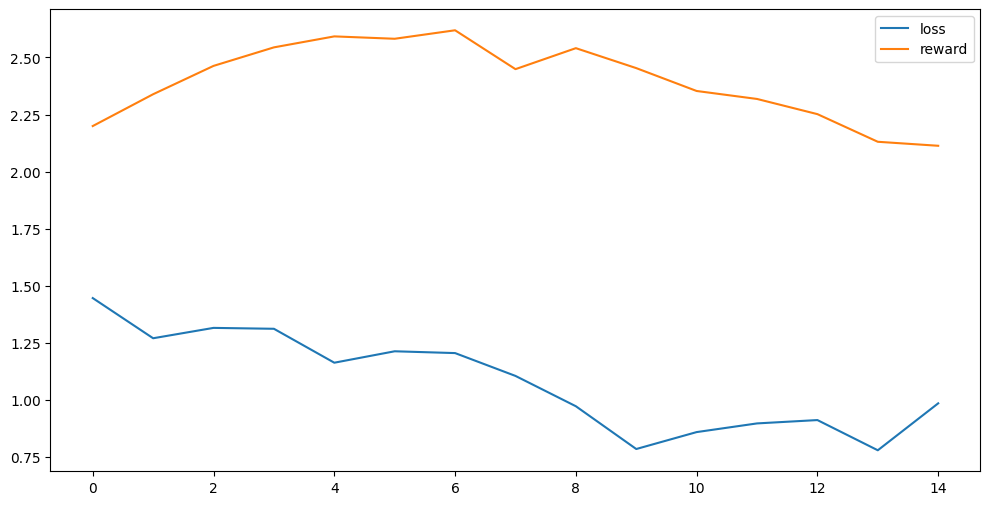

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(metrics['loss'], label='loss')
plt.plot(metrics['reward'], label='reward')
plt.legend()
plt.show()

Довольно странное поведение у графика Reward функции

In [18]:
from tqdm import trange

def RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons):
    mask_layer1 = torch.rand(max_layer1_neurons) > 0.5
    mask_layer2 = torch.rand(max_layer2_neurons) > 0.5
    return mask_layer1.float(), mask_layer2.float()

rnd_mlp_model = DynamicMLP(input_dim, max_layer1_neurons, max_layer2_neurons, output_dim)
num_iterations = 50

best_reward = -float('inf')
best_mask = RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons)

for i in trange(num_iterations):
    mask_layer1, mask_layer2 = RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons)

    rnd_mlp_model.apply_mask(mask_layer1, mask_layer2)
    valid_ppl = evaluate(rnd_mlp_model, testloader)
    reward = 10 / valid_ppl

    if reward > best_reward:
        best_reward = reward
        best_mask = mask_layer1, mask_layer2
        print(f"New Best Reward: {best_reward:.6f}")

rnd_mlp_model.apply_mask(*best_mask)

  2%|▏         | 1/50 [00:08<07:20,  8.99s/it]

New Best Reward: 1.001954


  6%|▌         | 3/50 [00:16<03:53,  4.96s/it]

New Best Reward: 1.002527


 50%|█████     | 25/50 [01:37<01:32,  3.70s/it]

New Best Reward: 1.003506


100%|██████████| 50/50 [03:10<00:00,  3.80s/it]


Видим, что RandomSelectionSearch не может получить модель с reward сильно выше 1, в отличие от ENAS

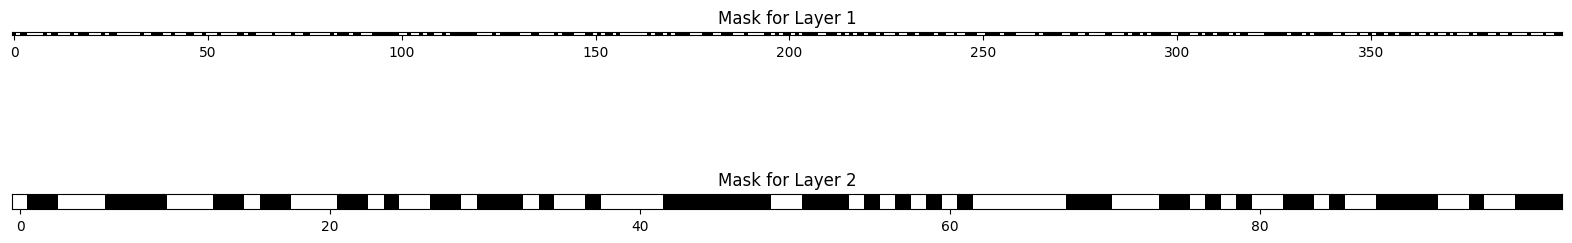

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_masks(mask_layer1, mask_layer2):
    mask_layer1_np = mask_layer1.cpu().numpy()
    mask_layer2_np = mask_layer2.cpu().numpy()

    # Визуализация маски для слоя 1
    plt.figure(figsize=(20, 4))
    plt.subplot(2, 1, 1)
    plt.imshow(mask_layer1_np[np.newaxis, :], cmap='binary')
    plt.title("Mask for Layer 1")
    plt.yticks([])

    # Визуализация маски для слоя 2
    plt.subplot(2, 1, 2)
    plt.imshow(mask_layer2_np[np.newaxis, :], cmap='binary')
    plt.title("Mask for Layer 2")
    plt.yticks([])

    plt.show()

visualize_masks(mlp_model.mask_layer1, mlp_model.mask_layer2)

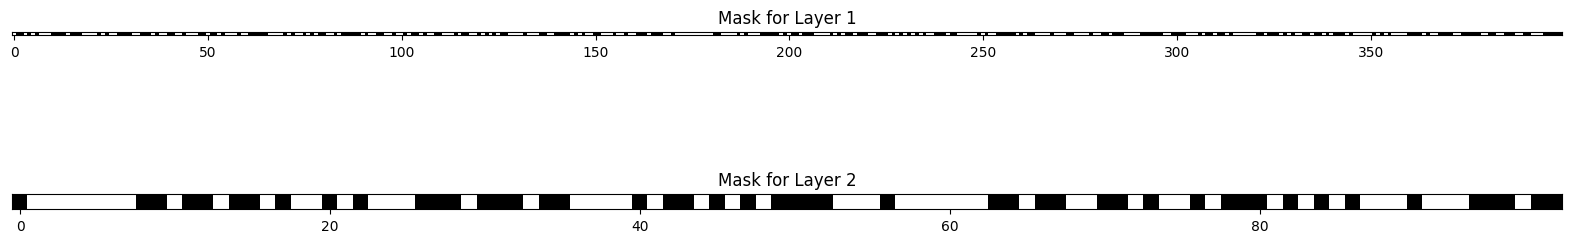

In [20]:
# best_mask -- лучшие маски для RandomSelectionSearch
visualize_masks(*best_mask)